# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
pip install protobuf tqdm wheel

In [0]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

Cloning into 'bigartm'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 16211 (delta 35), reused 51 (delta 34), pack-reused 16139
Receiving objects: 100% (16211/16211), 17.05 MiB | 20.49 MiB/s, done.
Resolving deltas: 100% (11303/11303), done.


In [0]:
!cd bigartm

In [0]:
%cd bigartm
!ls

/root/school_batches/bigartm
3rdparty	    CMakeLists.txt	 csharp       python	 test_data
appveyor-mingw.yml  cmake_modules	 docs	      README.md  utils
appveyor.yml	    codestyle_checks.sh  LICENSE.txt  src


In [0]:
!mkdir build
%cd build
!ls
!cmake ..
!make 

In [0]:
pip install python/bigartm*.whl

In [0]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [0]:
%cd ~/
!ls

/root
school_batches


In [0]:
!mkdir school_batches
%cd school_batches

mkdir: cannot create directory ‘school_batches’: File exists
/root/school_batches


In [0]:
import urllib.request

testfile = urllib.request.URLopener()
testfile.retrieve("https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_9/datasets/school.txt", "school.txt")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  exec(code_obj, self.user_global_ns, self.user_ns)


('school.txt', <http.client.HTTPMessage at 0x7fb809ffcc88>)

In [0]:
!ls

bigartm
bigartm.e0f2ccae6612.invalid-user.log.ERROR.20190710-044203.134
bigartm.e0f2ccae6612.invalid-user.log.INFO.20190710-043650.134
bigartm.e0f2ccae6612.invalid-user.log.WARNING.20190710-044203.134
bigartm.ERROR
bigartm.INFO
bigartm.WARNING
school_batches
school.txt


In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [0]:

T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

In [0]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [0]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [0]:
model_artm.initialize('dictionary')

Создаем словарь и инициализируем модель с его помощью

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

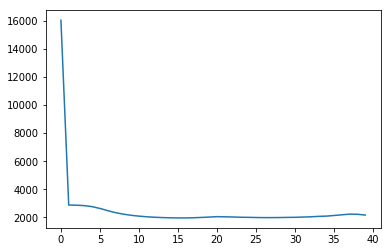

In [0]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [0]:
for topic_name in model_artm.topic_names:
    print (f'{topic_name} : ')
    tokens = model_artm.score_tracker["top_words"].last_tokens   
    print (*tokens[topic_name], sep = ", ")
    print()

sbj0 : 
который, быть, что, это, человек, этот, как, свой, для, они, его, весь, такой, время, себя

sbj1 : 
возведение, a, b, множитель, раскладывать, x, выражение, умножение, скобка, разложение, сокращенный, квадрат, ответ, переменный, целый

sbj2 : 
обособление, куприн, слово, раскольников, мастер, роман, словосочетание, маргарита, подчинительный, соня, оборот, вера, браслет, старик, сантьяго

sbj3 : 
который, быть, год, свой, время, государство, человек, мир, становиться, северный, жизнь, первый, война, африка, ребенок

sbj4 : 
x, a, b, уравнение, дробь, квадратный, y, степень, функция, число, f, решение, корень, c, пример

sbj5 : 
быть, пушкин, год, функция, свой, его, русский, который, поэт, империя, a, культура, весь, f, трение

sbj6 : 
сила, быть, тело, энергия, поле, при, магнитный, точка, географический, наречие, если, частица, например, заряд, величина

sbj7 : 
который, что, это, как, человек, для, этот, такой, быть, являться, мочь, себя, она, его, свой

sbj8 : 
который, быть

Давайте посмотрим также на разреженность матриц:

In [0]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333747148513794
0.1655462235212326


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary, class_ids=["text"]))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [0]:
for topic_name in model_artm.topic_names:
    print (f'{topic_name} : ')
    tokens = model_artm.score_tracker["top_words"].last_tokens   
    print (*tokens[topic_name], sep = ", ")
    print()

sbj0 : 
который, быть, что, это, этот, как, человек, свой, для, они, весь, такой, его, время, год

sbj1 : 


KeyError: ignored

Попробуем менять коэффициент регуляризации:

In [0]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [0]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
        print word,
    print

In [0]:
# еще раз посмотрим на разреженность
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9120814800262451
0.5050420165061951


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [0]:
model_artm.save("my_model")

In [0]:
model_artm.load("my_model")

NameError: ignored

Можно попросить матрицы в чистом виде:

In [0]:
phi = model_artm.get_phi()

In [0]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, скандальный)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, проучивать)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, бойкот)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, согрешение)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, заступаться)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, допрос)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, копилка)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, сомов)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000
"(text, дима)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000189,0.000000
"(text, ведомый)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000047,0.000000


Матрица вероятностей тем в документах.

In [0]:
theta = model_artm.get_theta()
theta

,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
sbj0,0.070946,0.052567,0.037453,0.035937,0.038462,0.155172,0.194030,0.029520,0.050676,0.081897,0.036254,0.030100,0.066879,0.063898,0.097859,0.019231,0.081325,0.117188,0.026505,0.026627,0.028112,0.024476,0.024221,0.033499,0.057471,0.034615,0.067416,0.028640,0.015755,0.044379,0.133803,0.040153,0.033457,0.026163,0.054878,0.047138,0.027607,0.047022,0.040752,0.072539,...,0.443193,0.499706,0.121495,0.416667,0.233766,0.221476,0.181818,0.263956,0.207792,0.135313,0.129755,0.284503,0.346535,0.247273,0.314411,0.280347,0.326360,0.270950,0.280597,0.272727,0.245454,0.179054,0.235772,0.216138,0.258555,0.371505,0.181244,0.055556,0.3350,0.380769,0.301370,0.214092,0.331104,0.430940,0.423349,0.530182,0.369681,0.180451,0.220339,0.463977
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.003378,0.008547,0.026217,0.002882,0.025641,0.005747,0.009950,0.000000,0.030405,0.000000,0.000000,0.006689,0.006369,0.000000,0.125382,0.000000,0.033133,0.023438,0.014634,0.008876,0.004016,0.010490,0.003460,0.009615,0.000000,0.011538,0.011236,0.016706,0.002457,0.029586,0.017606,0.015152,0.052045,0.002907,0.000000,0.020202,0.006135,0.015674,0.028213,0.018135,...,0.097276,0.016129,0.000000,0.008772,0.043290,0.010067,0.006734,0.046832,0.004329,0.006601,0.000000,0.019672,0.000000,0.000000,0.004367,0.043353,0.012552,0.036313,0.044776,0.002841,0.003030,0.010135,0.008130,0.034582,0.038023,0.052632,0.069164,0.000000,0.0100,0.003704,0.013699,0.013550,0.026756,0.011050,0.023881,0.011594,0.031915,0.037594,0.000000,0.092219
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.074324,0.306976,0.224719,0.638415

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [0]:
theta_test = model_artm.transform(batch_vectorizer)